# LSTM
Use sequence from GenCode files.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-03 15:03:50.816846
Python 3.10.6
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.losses import BinaryCrossentropy

EPOCHS=10
FOLDS=5
EMBED_DIMEN=4
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
#MINLEN=200
MINLEN=3000

from cell_lines import Cell_Lines
CELL_LINE_NUMBER=0

In [3]:
#DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'
DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Data Load

In [5]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-03 15:03:54.713323
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [6]:
# one hot
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
HOTS = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1], 'N':[0,0,0,0]}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                seq_chr = list(seq_txt)
                seq_hot = []
                for c in seq_chr:
                    one_hot = HOTS[c]
                    seq_hot.append(one_hot)
                allseq.append(seq_hot)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-11-03 15:03:54.751092
Load sequence
2022-11-03 15:03:58.021316
Num IDs: 5579
Num labels: 5579
Num counts: 5579


In [12]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [13]:
def build_model():
    DIMEN=4  # ONE HOT CATEGORIES
    ACT = 'sigmoid'
    rnn = Sequential()
    embed_layer = Embedding(DIMEN,EMBED_DIMEN,input_length=MAXLEN);
    # rnn1_layer = Bidirectional(
    rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
        #)
    rnn2_layer = Bidirectional(LSTM(16, return_sequences=True))
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(16,activation=ACT,dtype=dt)
    dense2_layer = Dense(16,activation=ACT,dtype=dt)
    output_layer = Dense(1,activation=ACT,dtype=dt)

    #rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    #rnn.add(dense1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [14]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-03 15:06:10.497141
COMPILE
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4000, 16)          1344      
                                                                 
 dense_8 (Dense)             (None, 4000, 1)           17        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    return cv_scores


Issues to address:

Where does the 16 come from?
Full shape received: (None, 4000, 4, 16)

Reduce dtype to int8?
Call arguments received by layer "sequential" "                 f"(type Sequential):
inputs=tf.Tensor(shape=(None, 4000, 4), dtype=int32)

2022-11-03 15:06:13.543414
2022-11-03 15:06:13.543414
splitting
Fold 1
Train sizes (4473, 4000, 4) (4473, 1)
Valid sizes (1106, 4000, 4) (1106, 1)
Train set ones/size 1989 / 4473
Valid set ones/size 487 / 1106
BUILD MODEL
COMPILE
FIT
2022-11-03 15:06:21.965903
Epoch 1/10
140/140 [==============================] - 87s 609ms/step - loss: 0.6534 - accuracy: 0.6033 - val_loss: 0.6238 - val_accuracy: 0.6531
Epoch 2/10
140/140 [==============================] - 85s 606ms/step - loss: 0.6206 - accuracy: 0.6520 - val_loss: 0.6163 - val_accuracy: 0.6632
Epoch 3/10
140/140 [==============================] - 85s 605ms/step - loss: 0.6069 - accuracy: 0.6711 - val_loss: 0.6161 - val_accuracy: 0.6781
Epoch 4/10
140/140 [==============================] - 85s 605ms/step - loss: 0.6271 - accuracy: 0.6519 - val_loss: 0.6204 - val_accuracy: 0.6630
Epoch 5/10
140/140 [==============================] - 85s 606ms/step - loss: 0.6158 - accuracy: 0.6756 - val_loss: 0.6185 - val_accuracy: 0.6711
Epoch 6/10
140

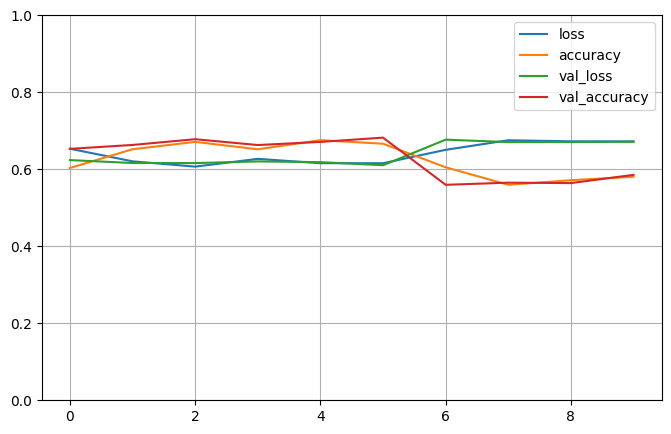

Compute valiation accuracy
2022-11-03 15:20:31.927388
accuracy: 58.55%
2022-11-03 15:20:37.093044
Fold 2
Train sizes (4432, 4000, 4) (4432, 1)
Valid sizes (1147, 4000, 4) (1147, 1)
Train set ones/size 1945 / 4432
Valid set ones/size 531 / 1147
BUILD MODEL
COMPILE
FIT
2022-11-03 15:20:45.462155
Epoch 1/10
139/139 [==============================] - 86s 605ms/step - loss: 0.6426 - accuracy: 0.6249 - val_loss: 0.6143 - val_accuracy: 0.6811
Epoch 2/10
139/139 [==============================] - 84s 607ms/step - loss: 0.6149 - accuracy: 0.6659 - val_loss: 0.6106 - val_accuracy: 0.6749
Epoch 3/10
139/139 [==============================] - 84s 605ms/step - loss: 0.6651 - accuracy: 0.5894 - val_loss: 0.6509 - val_accuracy: 0.6269
Epoch 4/10
139/139 [==============================] - 84s 605ms/step - loss: 0.6261 - accuracy: 0.6566 - val_loss: 0.6117 - val_accuracy: 0.6729
Epoch 5/10
139/139 [==============================] - 84s 605ms/step - loss: 0.6579 - accuracy: 0.6358 - val_loss: 0.6710 - v

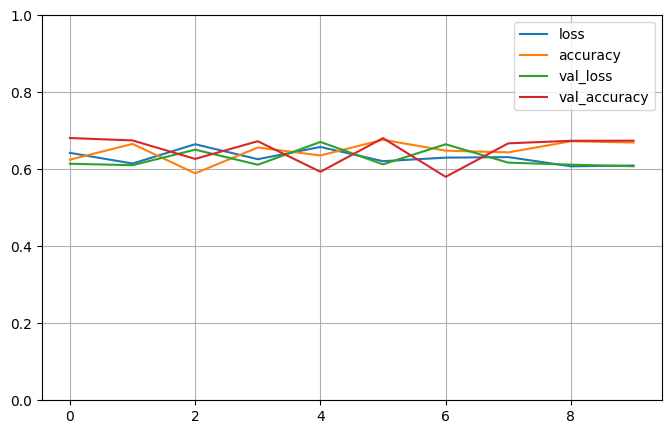

Compute valiation accuracy
2022-11-03 15:34:48.278509
accuracy: 67.43%
2022-11-03 15:34:53.660475
Fold 3
Train sizes (4398, 4000, 4) (4398, 1)
Valid sizes (1181, 4000, 4) (1181, 1)
Train set ones/size 1985 / 4398
Valid set ones/size 491 / 1181
BUILD MODEL
COMPILE
FIT
2022-11-03 15:35:02.024806
Epoch 1/10
138/138 [==============================] - 83s 590ms/step - loss: 0.6724 - accuracy: 0.5618 - val_loss: 0.6348 - val_accuracy: 0.6168
Epoch 2/10
138/138 [==============================] - 82s 594ms/step - loss: 0.6320 - accuracy: 0.6420 - val_loss: 0.6087 - val_accuracy: 0.6701
Epoch 3/10
138/138 [==============================] - 83s 599ms/step - loss: 0.6225 - accuracy: 0.6555 - val_loss: 0.6176 - val_accuracy: 0.6539
Epoch 4/10
138/138 [==============================] - 82s 596ms/step - loss: 0.6350 - accuracy: 0.6575 - val_loss: 0.6276 - val_accuracy: 0.6386
Epoch 5/10
138/138 [==============================] - 82s 593ms/step - loss: 0.6854 - accuracy: 0.5805 - val_loss: 0.6764 - v

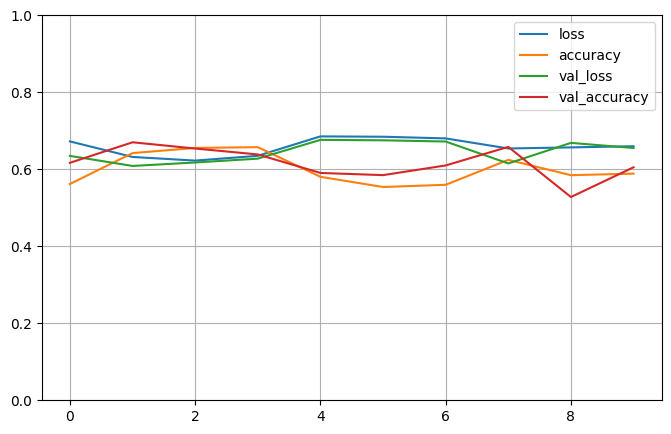

Compute valiation accuracy
2022-11-03 15:48:51.121382
accuracy: 60.51%
2022-11-03 15:48:56.850974
Fold 4
Train sizes (4517, 4000, 4) (4517, 1)
Valid sizes (1062, 4000, 4) (1062, 1)
Train set ones/size 1997 / 4517
Valid set ones/size 479 / 1062
BUILD MODEL
COMPILE
FIT
2022-11-03 15:49:05.458431
Epoch 1/10
142/142 [==============================] - 88s 608ms/step - loss: 0.6503 - accuracy: 0.6063 - val_loss: 0.6235 - val_accuracy: 0.6365
Epoch 2/10
142/142 [==============================] - 103s 726ms/step - loss: 0.6420 - accuracy: 0.6338 - val_loss: 0.6304 - val_accuracy: 0.6547
Epoch 3/10
142/142 [==============================] - 104s 729ms/step - loss: 0.6287 - accuracy: 0.6553 - val_loss: 0.6301 - val_accuracy: 0.6510
Epoch 4/10
142/142 [==============================] - 104s 732ms/step - loss: 0.6150 - accuracy: 0.6647 - val_loss: 0.6137 - val_accuracy: 0.6763
Epoch 5/10
142/142 [==============================] - 103s 727ms/step - loss: 0.6487 - accuracy: 0.6442 - val_loss: 0.6379

In [ ]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())